# Teste Elo7 - Data Science - Classificador

O objetivo desse projeto é fazer um classificador de produtos do site da Elo7.

## Descrição do dataset 

O dataset contém 38.507 registros distribuídos em 6 categorias (Bebê, Bijuterias e Jóias, Decoração, Lembrancinhas, Papel e Cia e Outros). Cada registro corresponde a um clique em um produto a partir de um termo de busca no site.

Nesse dataset você encontrará as seguintes colunas:
<ul>
    <li><b>product_id</b> - identificação de produto </li>
    <li><b>seller_id</b> - identificação do vendedor</li>
    <li><b>query</b> - termo de busca inserido pelo usuário</li>
    <li><b>search_page</b> - número da página que o produto apareceu nos resultados de busca (mín 1 e máx 5)</li>
    <li><b>position</b> - número da posição que o produto apareceu dentro da página de busca (mín 0 e máx 38)</li>
    <li><b>title</b> - título do produto</li>
    <li><b>concatenated_tags</b> - tags do produto inseridas pelo vendedor (as tags estão concatenadas por espaço)</li>
    <li><b>creation_date</b> - data de criação do produto na plataforma do Elo7</li>
    <li><b>price</b> - preço do produto em reais</li>
    <li><b>weight</b> - peso em gramas da unidade do produto reportado pelo vendedor</li>
    <li><b>express_delivery</b> - indica se o produto é pronta entrega (1) ou não (0)</li>
    <li><b>minimum_quantity</b> - quantidade de unidades mínima necessária para compra</li>
    <li><b>view_counts</b> - número de cliques no produto nos últimos três meses</li>
    <li><b>order_counts</b>- número de vezes que o produto foi comprado nos últimos três meses</li>
    <li><b>category</b> - categoria do produto</li>
</ul>

## Importando...

In [1]:
import pandas as pd
import numpy as np
import joblib
from scipy import interp

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 1 - Carregando os dados

In [2]:
data = pd.read_csv("dataset/elo7_recruitment_dataset.csv")
data.head(10)

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração
5,4336889,3436479,dia dos pais,1,37,Álbum de figurinhas dia dos pais,albuns figurinhas pai lucas album fotos,2018-07-11 10:41:33,49.970000,208.0,1,1,1093,NaN,Lembrancinhas
6,7544556,7118324,arranjo de flores para mesa,1,9,Arranjo de Flores - Orquidias,mini arranjos,2016-04-22 13:34:16,23.670000,207.0,1,5,276,NaN,Decoração
7,10869150,5203458,lembrancinha maternidade,5,18,Kit Aromarizador + sacola / Lembrancinha Mater...,bb lembrancinhas maternidade baby lembranca ma...,2017-10-05 00:26:02,12.710000,55.0,0,33,1178,109.0,Lembrancinhas
8,13193769,2933585,chaveiro dia dos pais,1,35,chaveiro dia dos pais,dia pais,2018-07-04 12:47:49,11.420000,6.0,1,23,72,NaN,Lembrancinhas
9,13424151,8530613,manta personalizada,1,20,Manta para bebê personalizada de Nuvem com nome,nascimento manta baby cha bebe vestido bebe,2018-04-03 16:10:51,107.100000,9.0,1,1,639,26.0,Bebê


## 2 - Limpeza dos dados

In [3]:
data.shape

(38507, 15)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38507 entries, 0 to 38506
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         38507 non-null  int64  
 1   seller_id          38507 non-null  int64  
 2   query              38507 non-null  object 
 3   search_page        38507 non-null  int64  
 4   position           38507 non-null  int64  
 5   title              38507 non-null  object 
 6   concatenated_tags  38505 non-null  object 
 7   creation_date      38507 non-null  object 
 8   price              38507 non-null  float64
 9   weight             38449 non-null  float64
 10  express_delivery   38507 non-null  int64  
 11  minimum_quantity   38507 non-null  int64  
 12  view_counts        38507 non-null  int64  
 13  order_counts       18117 non-null  float64
 14  category           38507 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 4.4+ MB


Alguns atributos possuem valores nulos... quantos são?

In [5]:
data.isnull().sum()

product_id               0
seller_id                0
query                    0
search_page              0
position                 0
title                    0
concatenated_tags        2
creation_date            0
price                    0
weight                  58
express_delivery         0
minimum_quantity         0
view_counts              0
order_counts         20390
category                 0
dtype: int64

In [6]:
data[data['order_counts']==0]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category


O atributo <b>order_counts</b> se refere ao número de pedidos nos últimos 3 meses, portanto os valores nulos podem ser substituídos simplesmente por 0.

#### Substituindo valores nulos por 0...

In [7]:
data['order_counts'] = data['order_counts'].fillna(0)
data['order_counts'] = data['order_counts'].astype('int64')
data.dtypes

product_id             int64
seller_id              int64
query                 object
search_page            int64
position               int64
title                 object
concatenated_tags     object
creation_date         object
price                float64
weight               float64
express_delivery       int64
minimum_quantity       int64
view_counts            int64
order_counts           int64
category              object
dtype: object

In [8]:
data.isnull().sum()

product_id            0
seller_id             0
query                 0
search_page           0
position              0
title                 0
concatenated_tags     2
creation_date         0
price                 0
weight               58
express_delivery      0
minimum_quantity      0
view_counts           0
order_counts          0
category              0
dtype: int64

Há poucos valores nulos nas classes <b>concatenated_tags</b> e <b>weight</b> comparado com a quantidade de dados que temos, então basta removê-los.

#### Removendo valores nulos...

In [9]:
data.dropna(inplace=True)

In [10]:
data.isnull().sum()

product_id           0
seller_id            0
query                0
search_page          0
position             0
title                0
concatenated_tags    0
creation_date        0
price                0
weight               0
express_delivery     0
minimum_quantity     0
view_counts          0
order_counts         0
category             0
dtype: int64

## 3 - Análise exploratória dos dados

Descrição estatística de cada atributo do conjunto de dados: a média, o desvio padrão, os valores mínimos e máximos e os percentis de 25%, 50% (mediana) e 75%:

In [11]:
data.drop(['product_id','seller_id'], axis=1).describe()

,search_page,position,price,weight,express_delivery,minimum_quantity,view_counts,order_counts
count,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000
mean,1.491690,16.892918,84.122273,361.747965,0.780555,14.603766,545.986397,12.901709
std,0.980153,11.589345,211.952413,1820.777260,0.413876,43.800200,1417.489218,43.743231
min,1.000000,0.000000,0.070000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,6.000000,12.760000,6.000000,1.000000,3.000000,119.000000,0.000000
50%,1.000000,16.000000,28.529999,9.000000,1.000000,7.000000,243.000000,0.000000
75%,2.000000,27.000000,90.000000,107.000000,1.000000,16.000000,521.000000,14.000000
max,5.000000,38.000000,11509.380000,65009.000000,1.000000,3000.000000,45010.000000,2460.000000


#### Distribuição dos dados entre as classes <a id='pie_plot'></a>

In [12]:
data['category'].value_counts()

Lembrancinhas         17746
Decoração              8836
Bebê                   7015
Papel e Cia            2762
Outros                 1137
Bijuterias e Jóias      951
Name: category, dtype: int64

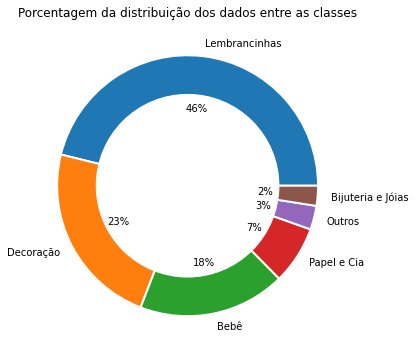

In [13]:
plt.figure(figsize=(12,6))

#definindo o gráfico de setores
plt.pie(data["category"].value_counts().values,
labels=["Lembrancinhas","Decoração",'Bebê','Papel e Cia', 'Outros', 'Bijuteria e Jóias'], autopct="%1.0f%%",
        wedgeprops={"linewidth":2,"edgecolor":"white"})

#estilizando...
plt.gca().add_artist(plt.Circle((0,0),.7,color = "white"))


plt.title("Porcentagem da distribuição dos dados entre as classes")
plt.show()

As classes são desbalanceadas, quase metade dos dados estão inseridos na categoria <b>Lembrancinha</b> (46%), três das seis categorias (<b>Bijuterias e Jóias, Outros, Papel e Cia</b>) representam apenas 12% dos dados.

#### Distribuição dos dados por tags

In [14]:
tags = data['concatenated_tags'].value_counts()
print(tags)
print(f'\nTotal de tags: {len(tags.values)}\n\n')

print("********************50 TAGS MAIS UTILIZADAS********************")
print(tags.head(50))

print("\n\n***************************************")
print(tags.describe())

dia pais                                                                 811
lembrancinhas                                                            194
batizado                                                                 116
tapetes                                                                   88
decoracao                                                                 71
                                                                        ... 
caixa lembrancinhas                                                        1
frases adesivos                                                            1
artesanato acessorios costura artesanato agulhas croche craft agulhas      1
cesto fio malha cestos tapetes cachepo croche                              1
itimalia amigurumi                                                         1
Name: concatenated_tags, Length: 22981, dtype: int64

Total de tags: 22981


********************50 TAGS MAIS UTILIZADAS********************
dia pais    

> O termo <b>dia pais</b> aparece com frequências nas tags, qual a porcentagem isso representa?

In [15]:
s = 0
for key,value in dict(zip(tags.index,tags.values)).items():
    if 'dia pais' in key:
        s = s + value
        
print(f'TOTAL DE TAGS DIA DOS PAIS: {s}\n')
print(f'Portanto {s*100/data.shape[0]:.2f}% dos produtos acessados se referem ao dia dos pais')

TOTAL DE TAGS DIA DOS PAIS: 2209

Portanto 5.75% dos produtos acessados se referem ao dia dos pais


#### Distribuição dos dados por queries

In [16]:
query = data['query'].value_counts()
print(query)

print("\n\n********50 QUERIES MAIS UTILIZADAS*********")
print(query.head(50))

print("\n\n****************************")
print(query.describe())

bolsa maternidade            153
dia dos pais                 148
lembrancinha dia dos pais    127
porta maternidade            126
batizado                     125
                            ... 
ballet                         1
moranguinho                    1
bolo para batizado             1
planta artificial              1
painel festa 30 anos           1
Name: query, Length: 6395, dtype: int64


********50 QUERIES MAIS UTILIZADAS*********
bolsa maternidade                       153
dia dos pais                            148
lembrancinha dia dos pais               127
porta maternidade                       126
batizado                                125
lembrancinha maternidade                122
lembrancinha                            122
lembrancinha batizado                   121
lembrancinhas maternidade               117
presente dia dos pais                   106
saida maternidade                       102
kit bolsa maternidade                    98
lembrancinha de batizad

> Nas queries mais utilizadas os termos <b>dia dos pais</b> e <b>maternidade</b> aparecem com frequência, qual a porcentagem isso representa?

In [17]:
dia_pais = 0
maternidade = 0 
for key,value in dict(zip(query.index,tags.values)).items():
    if 'dia dos pais' in key:
        dia_pais = dia_pais + value
    if 'maternidade' in key:
        maternidade = maternidade + value 
        
print(f'TOTAL DE QUERIES DIA DOS PAIS: {dia_pais}')
print(f'TOTAL DE QUERIES SOBRE MATERNIDADE: {maternidade}\n')
print(f'''Portanto em relação ao total dos dados {dia_pais*100/data.shape[0]:.2f}% 
dos registros se refere ao dia dos pais e {maternidade*100/data.shape[0]:.2f}% se refere a produtos de maternidade''')

TOTAL DE QUERIES DIA DOS PAIS: 1435
TOTAL DE QUERIES SOBRE MATERNIDADE: 1748

Portanto em relação ao total dos dados 3.73% 
dos registros se refere ao dia dos pais e 4.55% se refere a produtos de maternidade


#### Distribuição dos dados por vendedor

In [18]:
data_p_seller = data['seller_id'].value_counts()
print(data_p_seller.head(10))
print('\n********************************')
print(data_p_seller.describe())

1433098    242
4105092    162
9690400    123
2614254    113
3658570    106
1829032    104
1414443     99
5631760     98
2484177     94
440743      90
Name: seller_id, dtype: int64

********************************
count    8504.000000
mean        4.521049
std         8.346209
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       242.000000
Name: seller_id, dtype: float64


Quase 75% das vendedores possuem apenas 4 registros ou menos no conjuntos de dados, enquanto que o valor máximo é de 242, uma diferença considerável

> Qual a quantidade total de acessos aos produtos (<b>view_counts</b>) dos vendedores?

In [19]:
view_p_seller = data.groupby('seller_id')['view_counts'].sum().sort_values(ascending=False)
print(view_p_seller)
print('\n*********************************')
print(view_p_seller.describe())

seller_id
9627683    287970
3115141    237041
5573655    224003
6873472    219099
1433098    207712
            ...  
4006048         2
3346932         2
2752270         1
1659979         1
7906861         1
Name: view_counts, Length: 8504, dtype: int64

*********************************
count      8504.000000
mean       2468.431209
std        9183.559624
min           1.000000
25%         158.000000
50%         448.000000
75%        1577.000000
max      287970.000000
Name: view_counts, dtype: float64


> Qual a quantidade de vendas (<b>order_counts</b>) dos vendedores?

In [20]:
order_p_seller = data.groupby('seller_id')['order_counts'].sum().sort_values(ascending=False)
print(order_p_seller)
print('\n*********************************')
print(order_p_seller.describe())

seller_id
3465755    12044
1433098     9874
2906839     9859
9627683     6874
8201586     6622
           ...  
3354428        0
3351652        0
3351469        0
3350777        0
7972828        0
Name: order_counts, Length: 8504, dtype: int64

*********************************
count     8504.000000
mean        58.329257
std        320.213350
min          0.000000
25%          0.000000
50%          3.000000
75%         26.000000
max      12044.000000
Name: order_counts, dtype: float64


#### Distribuição dos dados por produto

In [21]:
data_p_prod = data['product_id'].value_counts()
print(data_p_prod.head(10))
print('\n********************************')
print(data_p_prod.describe())

7557702     14
11130723    12
4225282     12
9715550     11
2952037     11
12716324    11
14155651    11
240412      11
9059093     11
5395219     10
Name: product_id, dtype: int64

********************************
count    29748.000000
mean         1.292423
std          0.731863
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: product_id, dtype: float64


>  Qual a quantidade total de acessos (<b>view_counts</b>) dos produtos?

In [22]:
view_p_prod = data.groupby('product_id')['view_counts'].sum().sort_values(ascending=False)
print(view_p_prod)
print('\n*********************************')
print(view_p_prod.describe())

product_id
9730357     268150
6977307     207670
9836291     170003
8271183     156743
13672802    106783
             ...  
3175824          1
11975361         1
15866846         1
10116897         1
3645701          1
Name: view_counts, Length: 29748, dtype: int64

*********************************
count     29748.000000
mean        705.645388
std        3405.003338
min           1.000000
25%         106.000000
50%         219.000000
75%         502.000000
max      268150.000000
Name: view_counts, dtype: float64


> Qual a quantidade de vendas (<b>order_counts</b>) dos produtos?

In [23]:
order_p_prod = data.groupby('product_id')['order_counts'].sum().sort_values(ascending=False)
print(order_p_prod)
print('\n*********************************')
print(order_p_prod.describe())

product_id
7759771     8420
9730357     6112
9836291     3943
16390286    3499
6977307     3222
            ... 
11934957       0
6183976        0
11937126       0
11937400       0
8372000        0
Name: order_counts, Length: 29748, dtype: int64

*********************************
count    29748.000000
mean        16.674466
std        101.196880
min          0.000000
25%          0.000000
50%          0.000000
75%         15.000000
max       8420.000000
Name: order_counts, dtype: float64


> Quais são os produtos com mais de 100000 de acessos? E sua categoria?

In [24]:
filter_prod = view_p_prod.iloc[np.where(view_p_prod.values > 100000)]
print(filter_prod)

product_id
9730357     268150
6977307     207670
9836291     170003
8271183     156743
13672802    106783
Name: view_counts, dtype: int64


In [25]:
prod_100000 = data.loc[data['product_id'].isin(filter_prod.index)]
prod_100000.groupby('category')['product_id'].nunique()

category
Bebê             4
Lembrancinhas    1
Name: product_id, dtype: int64

#### Distribuição dos produtos por categoria

In [26]:
data.groupby('category')['product_id'].nunique().sort_values(ascending=False)

category
Lembrancinhas         12759
Decoração              7382
Bebê                   5442
Papel e Cia            2288
Outros                 1014
Bijuterias e Jóias      863
Name: product_id, dtype: int64

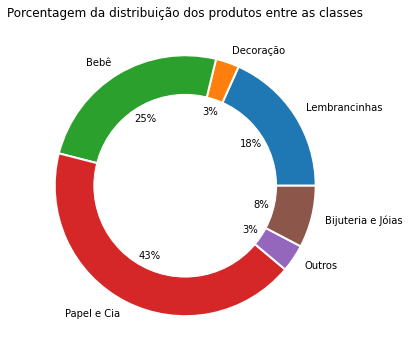

In [27]:
plt.figure(figsize=(12,6))

#definindo o gráfico de setores
plt.pie(data.groupby('category')['product_id'].nunique().values,
labels=["Lembrancinhas","Decoração",'Bebê','Papel e Cia', 'Outros', 'Bijuteria e Jóias'], autopct="%1.0f%%",
        wedgeprops={"linewidth":2,"edgecolor":"white"})

#estilizando...
plt.gca().add_artist(plt.Circle((0,0),.7,color = "white"))


plt.title("Porcentagem da distribuição dos produtos entre as classes")
plt.show()

A categoria <b>Papel e Cia</b> possui maior variedade de produtos, contudo como visto na distrubuição dos dados por categoria ([ver aqui](#pie_plot)), a categoria <b>Lembrancinhas</b> possui mais acessos 

> Qual o número de acessos (<b>view_counts</b>) por categoria?

In [28]:
view_p_cat = data.groupby('category')['view_counts'].sum().sort_values(ascending=False)
print(view_p_cat)
print('\n*************************************************************************')
print(data.groupby('category')['view_counts'].describe())

category
Lembrancinhas         9796217
Bebê                  5062706
Decoração             3851718
Papel e Cia           1193783
Outros                 556847
Bijuterias e Jóias     530268
Name: view_counts, dtype: int64

*************************************************************************
                      count        mean          std  min     25%    50%  \
category                                                                   
Bebê                 7015.0  721.697220  2193.610864  1.0  140.00  295.0   
Bijuterias e Jóias    951.0  557.589905  1567.102621  1.0   81.00  184.0   
Decoração            8836.0  435.911951  1186.403705  1.0  103.00  203.0   
Lembrancinhas       17746.0  552.023949  1179.856982  1.0  128.00  262.0   
Outros               1137.0  489.751099   972.444734  2.0  101.00  199.0   
Papel e Cia          2762.0  432.216872   968.316990  3.0   96.25  188.5   

                       75%      max  
category                             
Bebê               

> Qual o número de vendas (<b>order_counts</b>) por categoria?

In [29]:
order_p_cat = data.groupby('category')['order_counts'].sum().sort_values(ascending=False)
print(order_p_cat)
print('\n*************************************************************************')
print(data.groupby('category')['order_counts'].describe())

category
Lembrancinhas         201247
Bebê                  140462
Decoração              91789
Papel e Cia            24920
Bijuterias e Jóias     22284
Outros                 15330
Name: order_counts, dtype: int64

*************************************************************************
                      count       mean        std  min  25%   50%   75%  \
category                                                                  
Bebê                 7015.0  20.023093  57.203296  0.0  0.0   6.0  19.0   
Bijuterias e Jóias    951.0  23.432177  87.153956  0.0  0.0  10.0  23.0   
Decoração            8836.0  10.388072  35.957839  0.0  0.0   0.0  13.0   
Lembrancinhas       17746.0  11.340415  38.342891  0.0  0.0   0.0  12.0   
Outros               1137.0  13.482850  31.455534  0.0  0.0   1.0  16.0   
Papel e Cia          2762.0   9.022448  38.816261  0.0  0.0   0.0   8.0   

                       max  
category                    
Bebê                 907.0  
Bijuterias e Jóias  2

#### Distribuição dos dados por pronta entrega

In [30]:
data.groupby('express_delivery')['product_id'].nunique().sort_values(ascending=False)

express_delivery
1    23369
0     7409
Name: product_id, dtype: int64

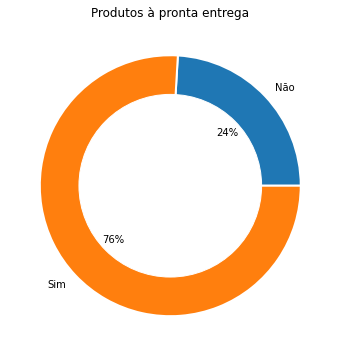

In [31]:
plt.figure(figsize=(12,6))

#definindo o gráfico de setores
plt.pie(data.groupby('express_delivery')['product_id'].nunique().values,
labels=['Não','Sim'], autopct="%1.0f%%",
        wedgeprops={"linewidth":2,"edgecolor":"white"})

#estilizando...
plt.gca().add_artist(plt.Circle((0,0),.7,color = "white"))


plt.title("Produtos à pronta entrega")
plt.show()

76% dos produtos estão disponíveis para pronta entrega e 24% não.

#### Distruibição por quantidade mínina

In [32]:
data['minimum_quantity'].describe()

count    38447.000000
mean        14.603766
std         43.800200
min          0.000000
25%          3.000000
50%          7.000000
75%         16.000000
max       3000.000000
Name: minimum_quantity, dtype: float64

Pelo menos 25% dos dados exigem quantidade mínima de 3 ou menos para comprar.

> Quais produtos tem quantidade mínina de 0 , 1 e 3000?

In [33]:
data[data['minimum_quantity'] == 0]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
21,14348923,7319287,berloque,1,18,Berloque,berloques,2015-06-14 13:40:07,16.08,6.0,0,0,13,0,Bijuterias e Jóias
38,3123993,6769616,colar de pedra,1,8,Pedra prisma,colares pedras naturais joias acessorios,2018-02-23 09:26:34,34.10,15.0,0,0,226,0,Bijuterias e Jóias
41,16441196,2347079,adesivo para roupas,1,4,"tachinhas para roupas, customização 50un",ilhos tachinhas rebites spikes customizacao tu...,2016-07-07 15:21:09,17.45,55.0,1,0,297,9,Outros
85,5687908,2629158,sousplat mdf,1,5,Sousplat MDF 35cm,casa suplat,2018-10-16 11:16:01,5.00,280.0,0,0,152,10,Decoração
94,15582859,7640886,anel falange,1,3,Anel de Falange com Zirconia,jewel anel pedidos,2016-03-02 09:04:52,27.00,5.0,0,0,3925,7,Bijuterias e Jóias
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38410,16267496,2037294,fraldas pintadas para menino,1,9,Fraldas pintadas menino,fraldas mantas,2017-02-08 20:47:22,65.80,208.0,0,0,39,0,Bebê
38424,14932230,2858343,globo terrestre,1,13,Globo Terrestre,globinhos,2019-05-22 21:14:22,198.33,261.0,0,0,57,10,Decoração
38441,6026509,4303271,lembrancinha aquario,1,15,Aquário de Garrafa,aquario,2019-03-28 20:24:41,31.65,667.0,0,0,47,17,Outros
38453,6427968,5561878,lembrancinha dia dos pais camisa,1,7,Lembrancinha masculina,lembranca dia pais lembrancinhas,2019-07-04 20:57:24,2.50,7.0,0,0,382,11,Lembrancinhas


In [34]:
data[data['minimum_quantity'] == 1]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,0,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1,Bebê
5,4336889,3436479,dia dos pais,1,37,Álbum de figurinhas dia dos pais,albuns figurinhas pai lucas album fotos,2018-07-11 10:41:33,49.970000,208.0,1,1,1093,0,Lembrancinhas
9,13424151,8530613,manta personalizada,1,20,Manta para bebê personalizada de Nuvem com nome,nascimento manta baby cha bebe vestido bebe,2018-04-03 16:10:51,107.100000,9.0,1,1,639,26,Bebê
16,4043364,7411250,lembrancinha de batismo,1,24,Lembrancinha de batizado,batizado lembrancinhas maternidade lembrancinh...,2016-10-24 21:59:36,12.620000,6.0,1,1,2979,33,Lembrancinhas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38477,12087312,1681917,presentes personalizados dia dos pais,2,8,Kit Presente Dia dos Pais,kit personalizados dia pais,2015-09-01 14:57:03,73.920000,1010.0,1,1,240,15,Lembrancinhas
38483,3817197,8415572,tapete redondo,1,14,Tapete Redondo de Crochê Quarto Bebê - 1m,itimalia tapetes menina tapetes redondo,2018-09-10 12:14:28,217.560000,1308.0,1,1,2439,14,Decoração
38489,9488501,1433098,lembrancinha dia dos pais,5,19,Caneca Personalizada Dia dos pais -Lembrancinh...,caneca personalizada dia pais lembrancinha dia...,2017-06-25 20:55:46,23.230000,606.0,1,1,184,21,Lembrancinhas
38496,5702671,2857393,porta fraldas,1,34,Porta fraldas para bolsa,porta fraldas bebe porta fraldas portatil kit ...,2016-05-29 11:02:11,59.880000,6.0,1,1,248,0,Bebê


In [35]:
data[data['minimum_quantity'] == 3000]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
32981,3528,1644793,tags,1,30,tags redondas,logo casamento tags melhores,2017-08-21 18:54:30,9.05,6.0,1,3000,1444,6,Papel e Cia


Os produtos com valor 0 para a quantidade mínima para compra parecem ter sido cadastrados errado...

### Explorando a correlação entre as variáveis...
<ul>
    <li> Correlação de Pearson: para verficar a correação linear entre as variáveis (variação de -1 a 1)</li>
    <li> Correlação de Spearman: para verificar a correlação não linear entre as variáveis (variação de -1 a 1)</li> 
<ul>

<b> Correlação de Pearson </b>

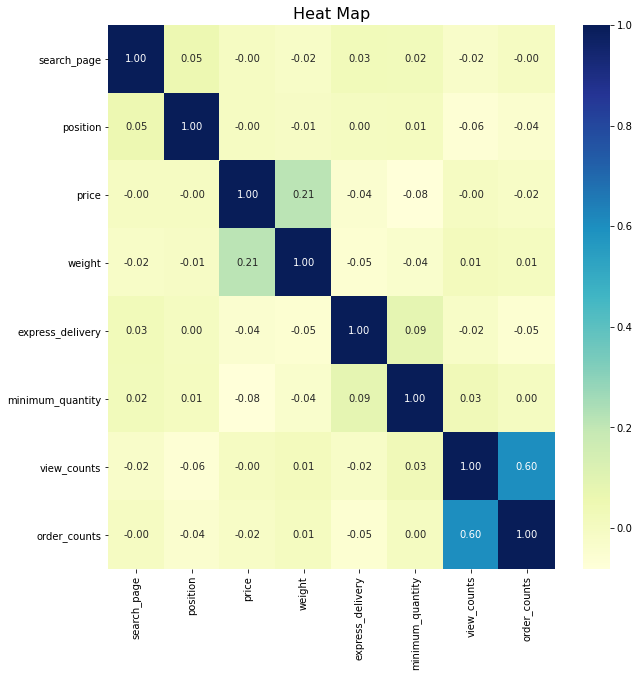

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(data.drop(['product_id','seller_id'], axis=1).corr(),annot=True,fmt='.2f', cmap="YlGnBu")
plt.title('Heat Map', fontsize=16)
plt.show()

#### Correlação de Spearman

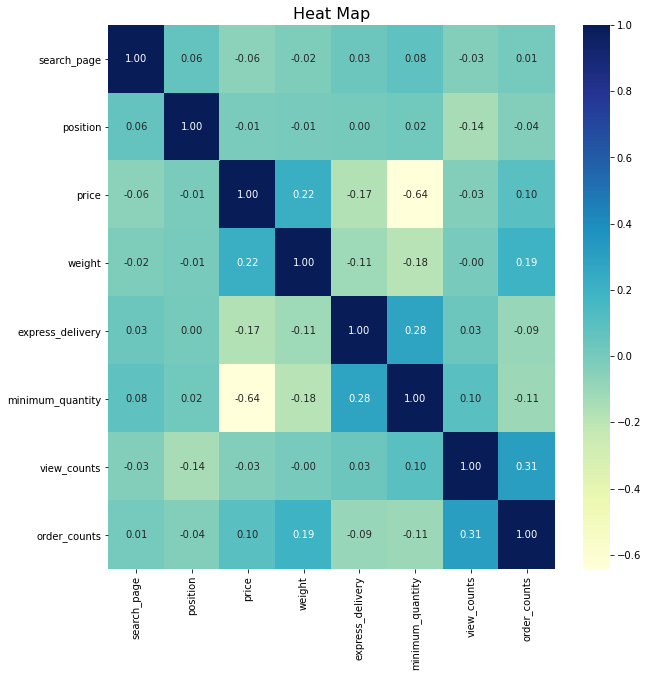

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(data.drop(['product_id','seller_id'], axis=1).corr(method='spearman'),annot=True,fmt='.2f', cmap="YlGnBu")
plt.title('Heat Map', fontsize=16)
plt.show()

Nota-se que as variáveis do problema não estão relacionadas. Os atributos <b>view_counts</b> e <b> order_counts </b> são os únicos que apresentaram correlação considerável, com valor de Pearson: 0,6 e Spearman: 0,31.

### Dispersão dos dados

[]

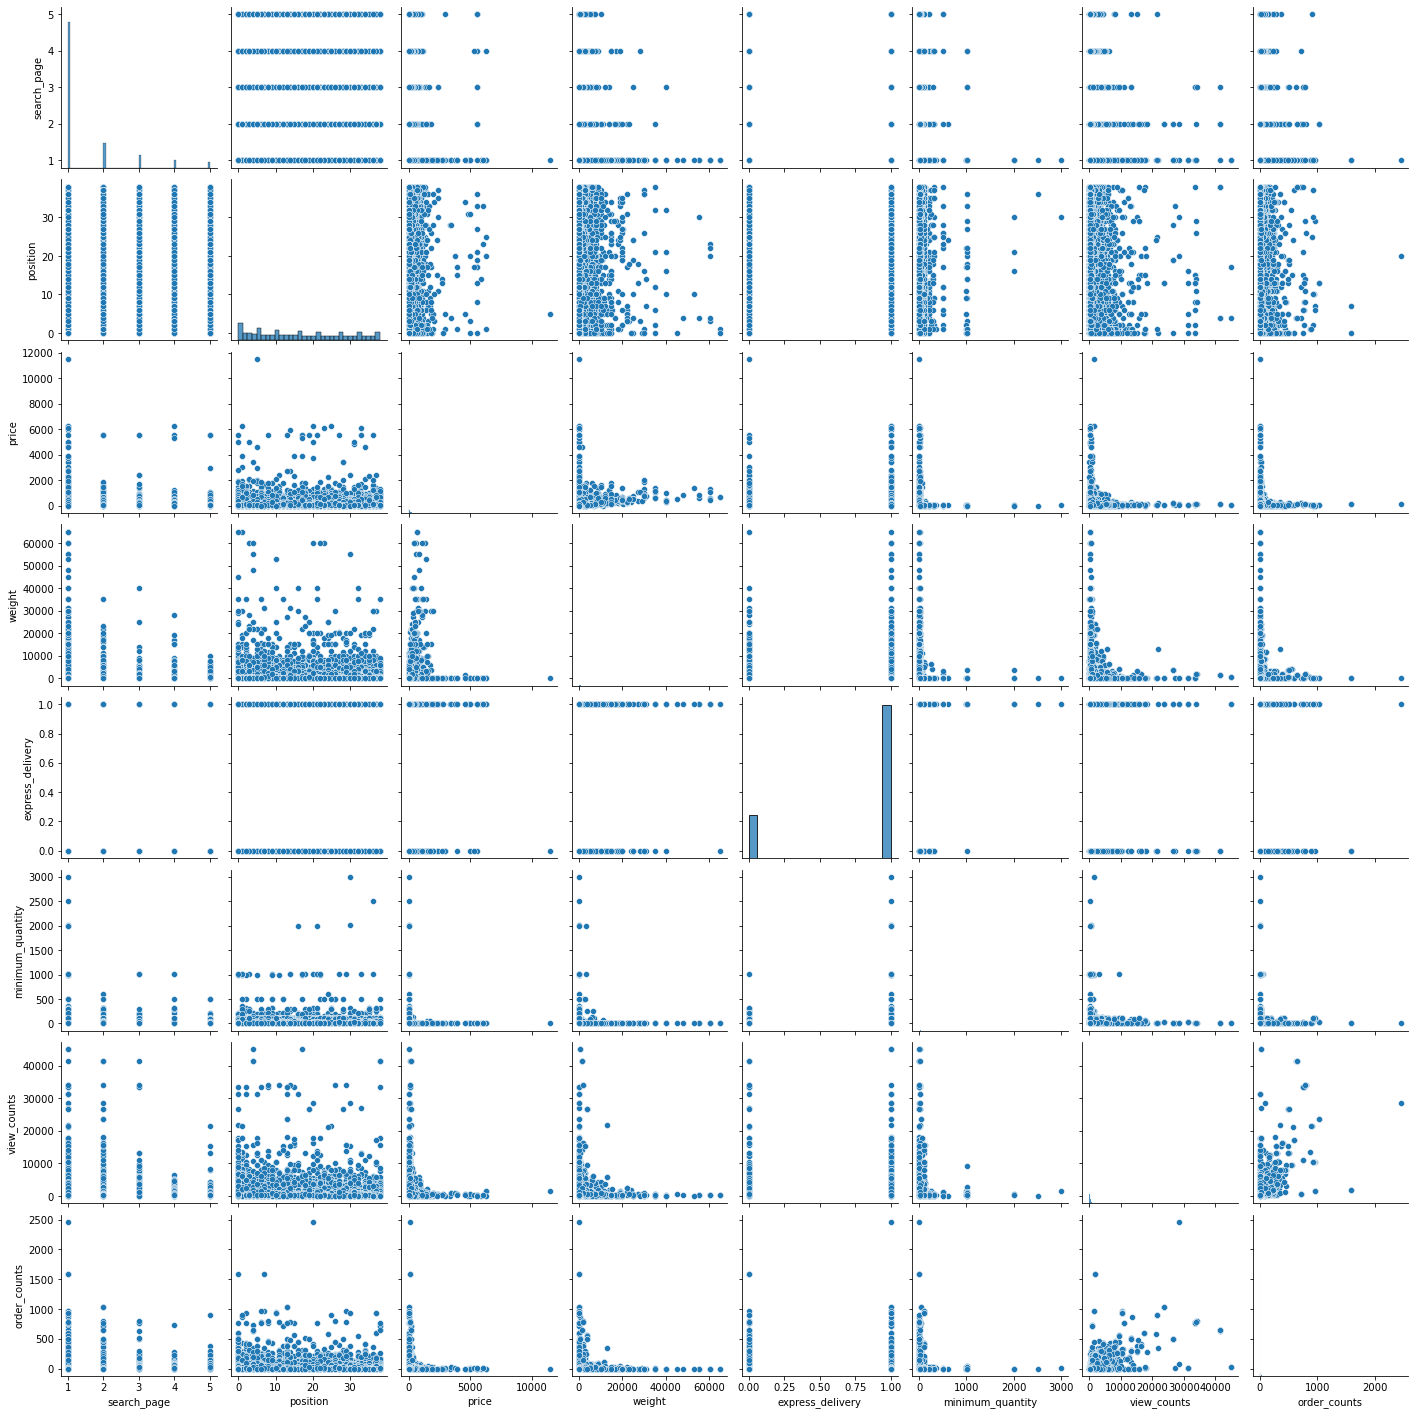

In [38]:
sns.pairplot(data.drop(['product_id','seller_id'], axis=1))
plt.plot()

### Densidade

<ul>
    <li> Visualização da distribuição de probabilidade dos dados </li> 
    <li> Os dados foram plotados com os valores originais e com a normalização (média = 0; desvio padrão = 1) - Distribuição Gaussiana</li> 
    <li> Os gráficos estão em escala logarítmica, pois o intervalo numérico das variáveis é extenso e não resulta em uma boa visualização da distribuição </li> 
</ul>

----------------------------- Dados normalizados --------------------------------------

In [39]:
scaler = StandardScaler()
columns = ['price', 'weight', 'minimum_quantity', 'view_counts', 'order_counts']
data_scaled = pd.DataFrame(scaler.fit_transform((data[columns])), columns=columns)

---------------------------- Gráficos da Densidade -------------------------------------

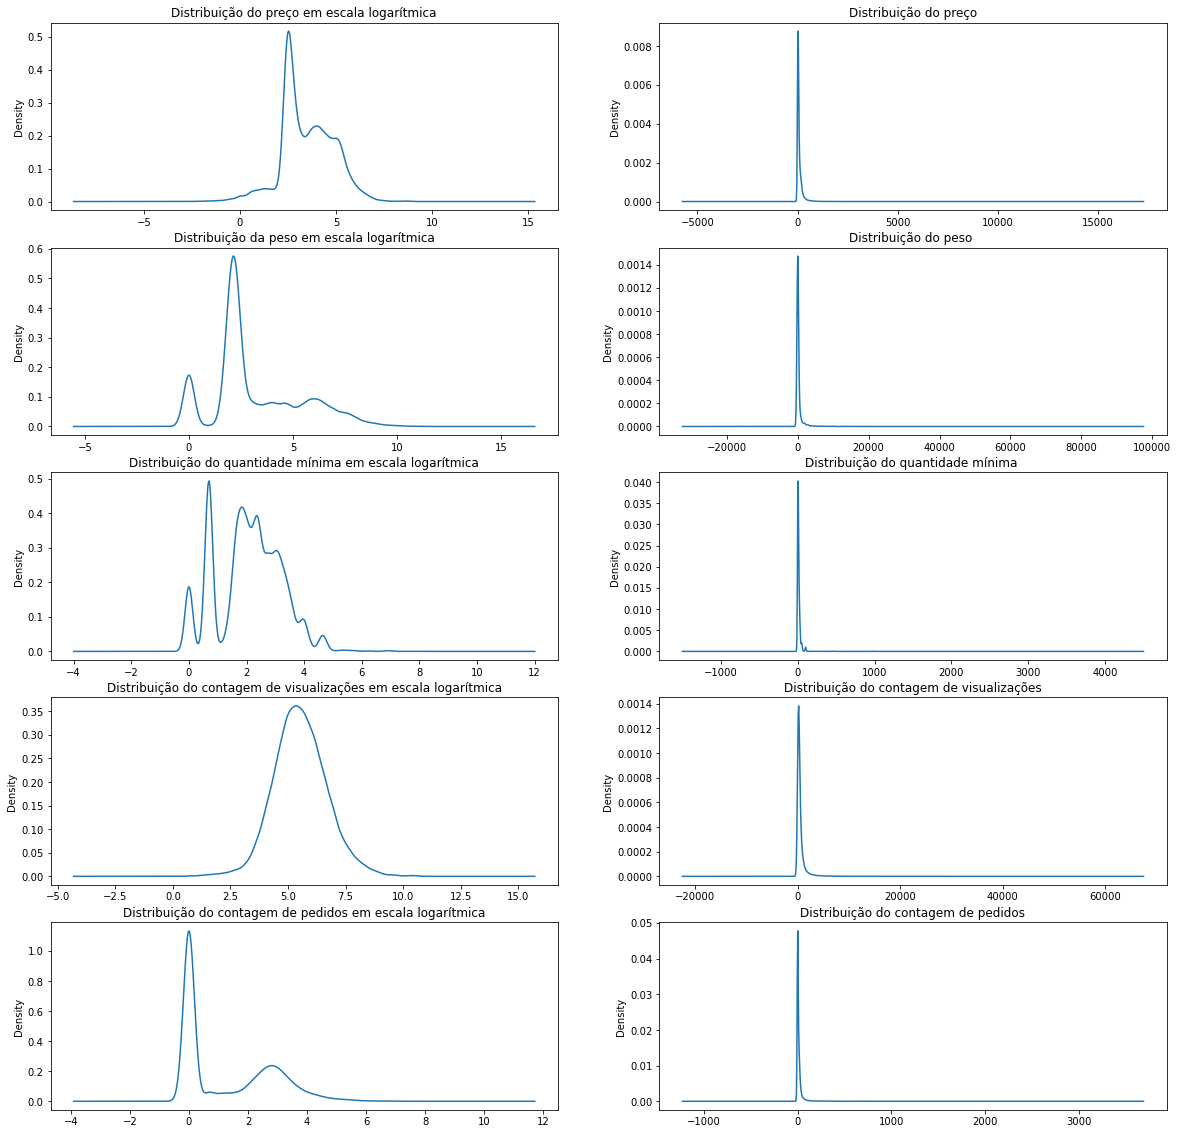

In [40]:
fig, axs = plt.subplots(5,2, figsize=(20,20))
np.log(data['price']).plot.kde(ax=axs[0][0])
data['price'].plot.kde(ax=axs[0][1])
np.log1p(data['weight']).plot.kde(ax=axs[1][0])
data['weight'].plot.kde(ax=axs[1][1])
np.log1p(data['minimum_quantity']).plot.kde(ax=axs[2][0])
data['minimum_quantity'].plot.kde(ax=axs[2][1])
np.log1p(data['view_counts']).plot.kde(ax=axs[3][0])
data['view_counts'].plot.kde(ax=axs[3][1])
np.log1p(data['order_counts']).plot.kde(ax=axs[4][0])
data['order_counts'].plot.kde(ax=axs[4][1])
axs[0][0].set_title('Distribuição do preço em escala logarítmica')
axs[0][1].set_title('Distribuição do preço')
axs[1][0].set_title('Distribuição da peso em escala logarítmica')
axs[1][1].set_title('Distribuição do peso ')
axs[2][0].set_title('Distribuição do quantidade mínima em escala logarítmica')
axs[2][1].set_title('Distribuição do quantidade mínima ')
axs[3][0].set_title('Distribuição do contagem de visualizações em escala logarítmica')
axs[3][1].set_title('Distribuição do contagem de visualizações')
axs[4][0].set_title('Distribuição do contagem de pedidos em escala logarítmica')
axs[4][1].set_title('Distribuição do contagem de pedidos')
plt.show()

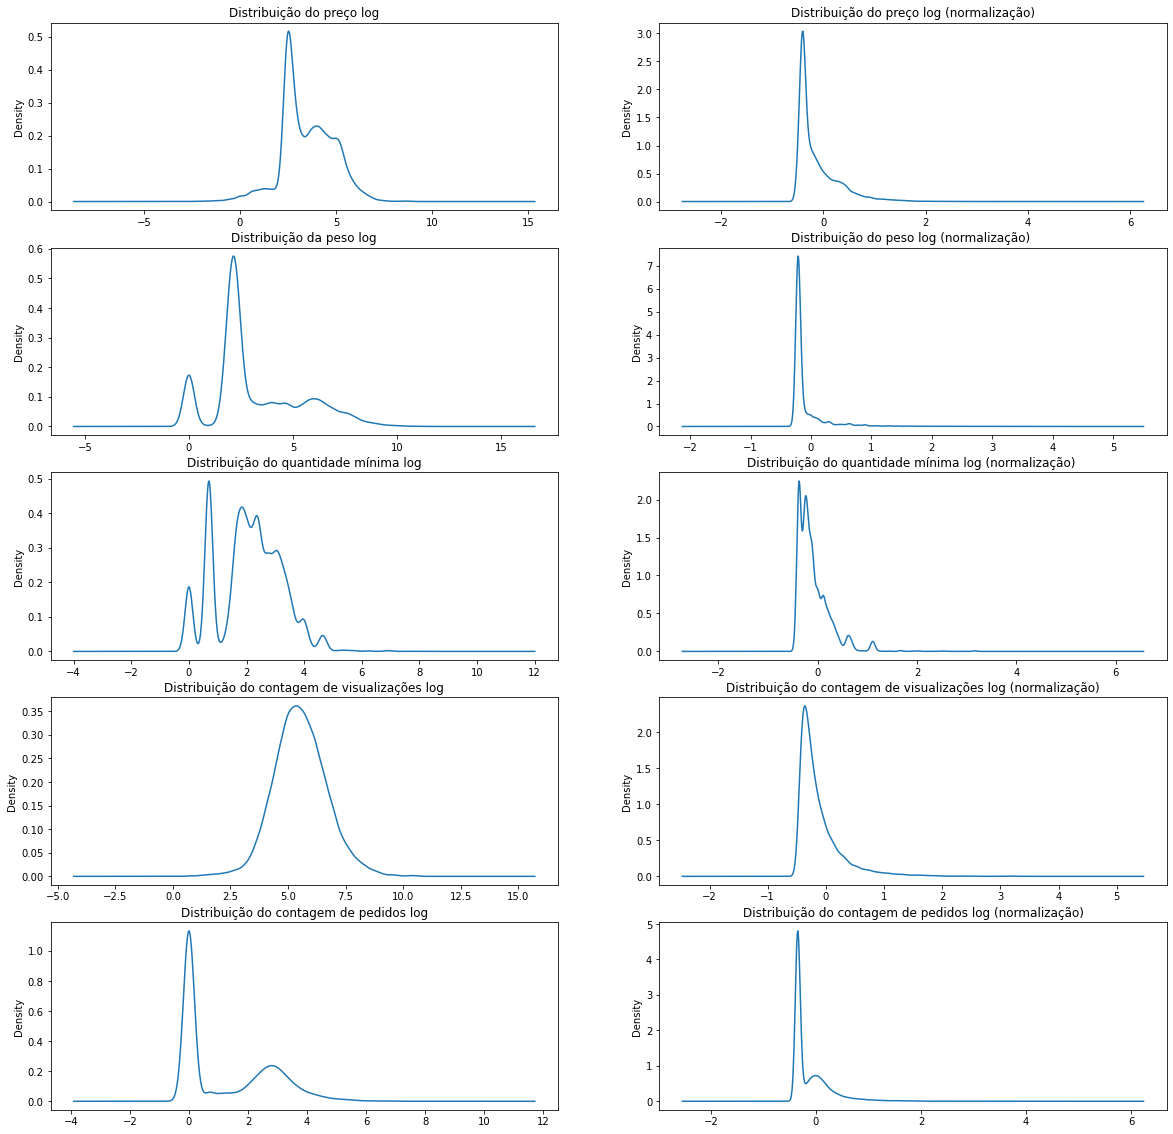

In [41]:
fig, axs = plt.subplots(5,2, figsize=(20,20))
np.log(data['price']).plot.kde(ax=axs[0][0])
np.log1p(data_scaled['price']).plot.kde(ax=axs[0][1])
np.log1p(data['weight']).plot.kde(ax=axs[1][0])
np.log1p(data_scaled['weight']).plot.kde(ax=axs[1][1])
np.log1p(data['minimum_quantity']).plot.kde(ax=axs[2][0])
np.log1p(data_scaled['minimum_quantity']).plot.kde(ax=axs[2][1])
np.log1p(data['view_counts']).plot.kde(ax=axs[3][0])
np.log1p(data_scaled['view_counts']).plot.kde(ax=axs[3][1])
np.log1p(data['order_counts']).plot.kde(ax=axs[4][0])
np.log1p(data_scaled['order_counts']).plot.kde(ax=axs[4][1])
axs[0][0].set_title('Distribuição do preço log')
axs[0][1].set_title('Distribuição do preço log (normalização)')
axs[1][0].set_title('Distribuição da peso log')
axs[1][1].set_title('Distribuição do peso log (normalização) ')
axs[2][0].set_title('Distribuição do quantidade mínima log')
axs[2][1].set_title('Distribuição do quantidade mínima log (normalização) ')
axs[3][0].set_title('Distribuição do contagem de visualizações log')
axs[3][1].set_title('Distribuição do contagem de visualizações log (normalização)')
axs[4][0].set_title('Distribuição do contagem de pedidos log')
axs[4][1].set_title('Distribuição do contagem de pedidos log (normalização)')
plt.show()

### Box Plot

<ul>
    <li> Visualização do Box plot de cada variável </li> 
    <li> Os dados foram plotados com os valores originais e com a normalização (média = 0; desvio padrão = 1) - Distribuição Gaussiana</li> 
    <li> Os gráficos estão em escala logarítmica, pois o intervalo numérico das variáveis é extenso e não resulta em uma boa visualização da distribuição </li> 
</ul>

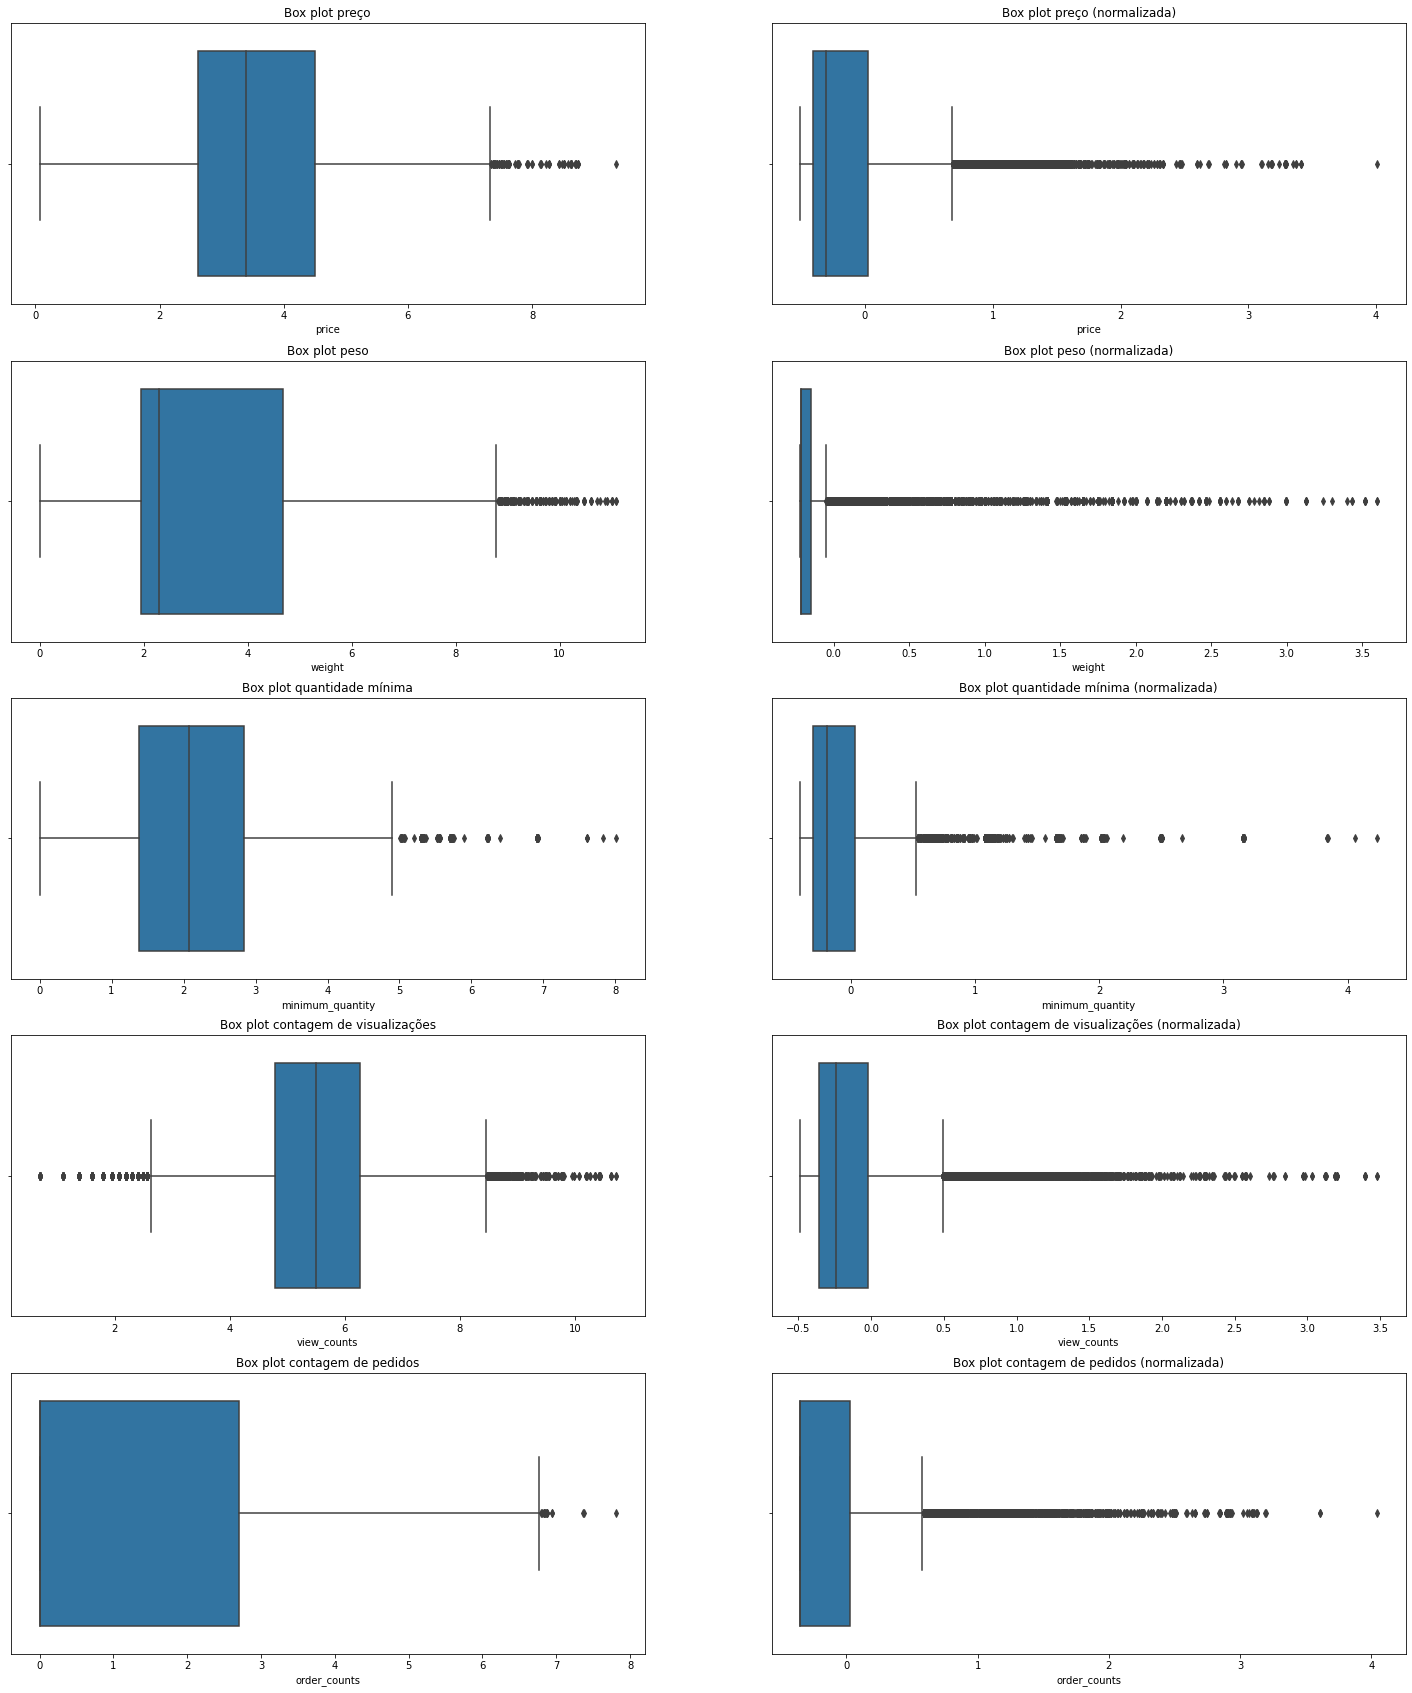

In [42]:
fig, axs = plt.subplots(5,2, figsize=(25,30))
sns.boxplot(x=np.log1p(data['price']),ax = axs[0][0])
sns.boxplot(x=np.log1p(data_scaled['price']), ax = axs[0][1])
sns.boxplot(x=np.log1p(data['weight']), ax = axs[1][0])
sns.boxplot(x=np.log1p(data_scaled['weight']), ax = axs[1][1])
sns.boxplot(x=np.log1p(data['minimum_quantity']), ax = axs[2][0])
sns.boxplot(x=np.log1p(data_scaled['minimum_quantity']), ax = axs[2][1])
sns.boxplot(x=np.log1p(data['view_counts']), ax = axs[3][0])
sns.boxplot(x=np.log1p(data_scaled['view_counts']), ax = axs[3][1])
sns.boxplot(x=np.log1p(data['order_counts']), ax = axs[4][0])
sns.boxplot(x=np.log1p(data_scaled['order_counts']), ax = axs[4][1])
axs[0][0].set_title('Box plot preço')
axs[0][1].set_title('Box plot preço (normalizada)')
axs[1][0].set_title('Box plot peso')
axs[1][1].set_title('Box plot peso (normalizada)')
axs[2][0].set_title('Box plot quantidade mínima')
axs[2][1].set_title('Box plot quantidade mínima (normalizada)')
axs[3][0].set_title('Box plot contagem de visualizações')
axs[3][1].set_title('Box plot contagem de visualizações (normalizada)')
axs[4][0].set_title('Box plot contagem de pedidos')
axs[4][1].set_title('Box plot contagem de pedidos (normalizada)')
plt.show()

Os dados possuem muitos outliers. Como a grande variação de valores é uma peculiaridade dos atributos dos dados, irei optar por não tratá-los, visto que a alteração pode enviesar os resultados.

## 4 - Classificação dos dados

Nessa seção os dados são classificados nas categorias: 
<ul>
    <li> Bebê </li>
    <li> Bijuterias e Jóias </li>
    <li> Decoração </li>
    <li> Lembrancinhas </li>
    <li> Papel e Cia </li>
    <li> Outros </li>
    
</ul>

Considerações:

<ul>
    <li> As variáveis estão em um intervalo numérico extenso e a distribuição é enviesada </li>
    <li> Não há correlação entre variáveis
    <li> Dados dispersos sem padrão aparente
    
</ul>

Passos:

<ul>
    <li> Vetorizar as queries </li>
    <li> Determinar importância das features e escolher a com maior relevância para a tarefa </li>
    <li> Dimensionar os dados </li>
    <li> Aplicar algoritmos de classificação supervisionada </li>
    <li> Avaliar e validar a abordagem </li>
</ul>

#### <hr style="height:0.5px;border-width:0;color:black;background-color:black">Definindo funções...

------------------------------- Função para plotar a matrix de confusão ---------------------------------------

In [43]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

------------------------------- Função para plotar a curva ROC ---------------------------------------

In [44]:
# Function to plot Receiver Operating Characteristic (ROC) curve
# Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_ROC_curve(y_true, y_score, n_classes, title):
    
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true,y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,
        label='ROC curve (area = {0:0.2f})'
        ''.format(roc_auc),
        color='darkorange', linestyle='-', linewidth=2)
    else:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        y_to_categ = np.zeros((y_true.size, 6), dtype=int)
        y_to_categ[np.arange(y_true.size), y_true] = 1
        y_true = y_to_categ
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                label='micro-average ROC curve (area = {0:0.3f})'
                 ''.format(roc_auc["micro"]),
                color='deeppink', linestyle='-', linewidth=2)
        plt.plot(fpr["macro"], tpr["macro"],
                label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
                color='darkorange', linestyle='-', linewidth=2)
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title(title)

---------------------------------------- Funções para computar as métricas -------------------------------------------

In [45]:
def metrics(y_true, y_pred, proba):
    result = np.random.randn(6)
    result[0] = accuracy_score(y_true,y_pred)
    result[1] = precision_score(y_true,y_pred,average='macro')
    result[2] = recall_score(y_true,y_pred,average='macro')
    result[3] = f1_score(y_true,y_pred,average='macro')
    result[4] = cohen_kappa_score(y_true,y_pred)
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_true)
    y_true = lb.transform(y_true)
    result[5] = roc_auc_score(y_true,proba, average='macro')
    return result

def print_metrics(metrics):
    print("Acurácia:              ", metrics[0])
    print("Precisão:              ", metrics[1])
    print("Revocação:             ", metrics[2])
    print("F1-score:              ", metrics[3])
    print("Cohen Kappa score:     ", metrics[4])
    print("ROC AUC score:         ", metrics[5])

#### <hr style="height:0.5px;border-width:0;color:black;background-color:black">Mapear as categorias para números

In [46]:
data['category'] = data.category.map({"Lembrancinhas":0,"Decoração":1,'Bebê':2,
                       'Papel e Cia':3,'Outros':4, 'Bijuterias e Jóias':5}).astype('int32')

In [47]:
data['category'].value_counts()

0    17746
1     8836
2     7015
3     2762
4     1137
5      951
Name: category, dtype: int64

#### <hr style="height:0.5px;border-width:0;color:black;background-color:black"> Vetorização com TF-IDF

Para vetorizar os dados nominais será aplicado o TF-IDF, pois esse método considera a frequência das palavras. Dessa maneira dando importância maior aos termos que aparecem mais no corpo linguístico.

In [48]:
text_query = data['query']
text_query = text_query.append(data['concatenated_tags'])

In [49]:
text_query

0                                           espirito santo
1                                         cartao de visita
2                                    expositor de esmaltes
3                      medidas lencol para berco americano
4                                     adesivo box banheiro
                               ...                        
38502                       senhora aparecida bebe perolas
38503                                        lembrancinhas
38504    despedida bianca metalizados xvdakaw lembranci...
38505                                         festa pijama
38506       tema musica instrumentos musicais festa musica
Length: 76894, dtype: object

In [50]:
vectorizer = TfidfVectorizer()
vectorizer.fit(text_query)
# joblib.dump(vectorizer,"models/TFIDF_elo7data.pkl")  # comando para salvar o modelo num .pkl

TfidfVectorizer()

In [51]:
len(vectorizer.get_feature_names())

8089

#### <hr style="height:0.5px;border-width:0;color:black;background-color:black">Seleção de atributos

Como visto na análise exploratória ([ver](#scatter)), os dados não estão correlacionados e portanto, apenas excluí-los por análise crua de correlação não é possível. 

O classficador terá obrigatoriamente uma variável nominal (<b>query</b>), para identificar as variáveis numéricas mais relevantes, optei por aplicar o método de classificação, que também pode ser usado como feature selector, chamado Extra Tree Classifier.

O Extra Tree Classifier agrega os resultados de várias árvores de decisão descorrelacionadas coletadas em uma "floresta" para produzir seu resultado de classificação.

In [52]:
columns_filter = ['price', 'weight', 'minimum_quantity', 'view_counts', 'order_counts','search_page', 'position','category']
array = data[columns_filter].values
X = array[:,0:7]
Y = array[:,7]
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)

[0.28107453 0.18116234 0.17619406 0.15803394 0.08859778 0.00944823
 0.10548913]


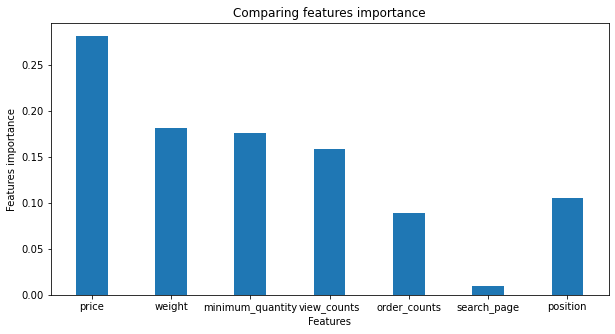

In [53]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(columns_filter[:-1], model.feature_importances_, width = 0.4)

plt.xlabel("Features")
plt.ylabel("Features importance")
plt.title("Comparing features importance")
plt.show()

De acordo com a árvore construída do algoritmo, a variável <b>price</b> é a mais importante para determinar os resultados da classficação. Como ela está bem a frente das outras em termos de relevância, irei usar ela para a tarefa de classificação.

#### <hr style="height:0.5px;border-width:0;color:black;background-color:black">Divisão do conjunto para treino e teste

O treinamento será feito com os atributos <b>query</b> e <b>price</b>. Aqui é feita a separação dos dados em treino de teste na proporção de 25% teste e 75% treino.

In [54]:
X = data[['query', 'price']]
y = data['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(38447, 2) (38447,)
(28835, 2) (28835,)
(9612, 2) (9612,)


In [55]:
X_train_dtm = vectorizer.transform(X_train['query']).toarray()
X_test_dtm = vectorizer.transform(X_test['query']).toarray()

X_train_price = np.log1p(X_train['price'].to_numpy().reshape(-1,1))
X_test_price = np.log1p(X_test['price'].to_numpy().reshape(-1,1))

X_train_dtm = np.concatenate((X_train_dtm, X_train_price), axis = 1)
X_test_dtm = np.concatenate((X_test_dtm, X_test_price), axis = 1)

In [56]:
X_train_dtm

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.11511542],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.5138722 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.64048762],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        4.2037967 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.24990174],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.73825604]])

#### <hr style="height:0.5px;border-width:0;color:black;background-color:black">Aplicação do classificador

---------------------------------- SVM ---------------------------------------------

A SVM é um modelo robusto para classificação. O algoritmo é capaz de separar os dados através de um hiperplano. Nesse caso, optei pelo kernel linear e a ideia é que essa técnica seja a melhor para classificar dados dispersos e com muitos zeros. Digo isso, pois os dados nominais serão representados por vetores esparsos (TF-IDF) e terá muitos valores iguais a 0.

Apenas para efeito de comparação, aplicarei outros métodos clássicos: Naive Bayes e Regressão Logística.

In [57]:
classifier = LinearSVC(class_weight='balanced') 
%time classifier.fit(X_train_dtm, y_train) 
y_pred_class = classifier.predict(X_test_dtm)
y_score = classifier.fit(X_train_dtm, y_train).decision_function(X_test_dtm)

#joblib.dump(classifier,"models/SVM_elo7data.pkl") # comando para salvar o modelo num .pkl

Wall time: 15.2 s


In [58]:
print('*'*15, 'Report metrics','*'*25)
print_metrics(metrics(y_test, y_pred_class, y_score))
print('*'*55)

*************** Report metrics *************************
Acurácia:               0.8425925925925926
Precisão:               0.7593902837338615
Revocação:              0.8066874081019031
F1-score:               0.7801341327183953
Cohen Kappa score:      0.7737496002723787
ROC AUC score:          0.9566425410188354
*******************************************************


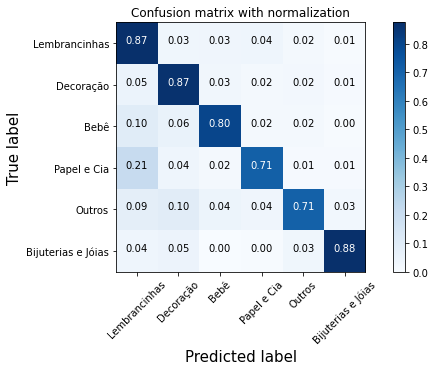

In [59]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,5))
plot_confusion_matrix(cnf_matrix, classes=["Lembrancinhas","Decoração",'Bebê',
                       'Papel e Cia','Outros','Bijuterias e Jóias'],normalize=True,
                      title='Confusion matrix with normalization')

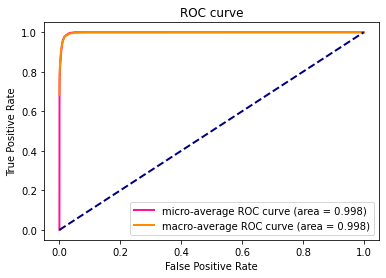

In [60]:
plot_ROC_curve(y_pred_class, y_score, 6, 'ROC curve')

------------------------------------ Naive Bayes -----------------------------------------

In [61]:
nb = MultinomialNB() 
%time nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
y_score = nb.predict_proba(X_test_dtm)

Wall time: 864 ms


In [62]:
print('*'*15, 'Report metrics','*'*25)
print_metrics(metrics(y_test, y_pred_class, y_score))
print('*'*55)

*************** Report metrics *************************
Acurácia:               0.7925509779442363
Precisão:               0.884273057613422
Revocação:              0.47940164407499947
F1-score:               0.5024456579614526
Cohen Kappa score:      0.6787266542318833
ROC AUC score:          0.9430758133182463
*******************************************************


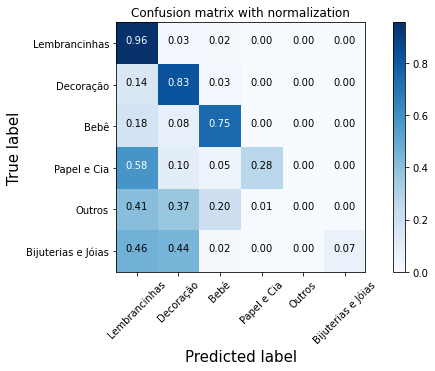

In [63]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,5))
plot_confusion_matrix(cnf_matrix, classes=["Lembrancinhas","Decoração",'Bebê',
                       'Papel e Cia','Outros','Bijuterias e Jóias'],normalize=True,
                      title='Confusion matrix with normalization')

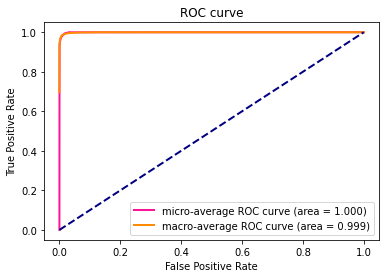

In [64]:
plot_ROC_curve(y_pred_class, y_score, 6, 'ROC curve')

------------------------------- Regressão Logística -----------------------------------

In [65]:
logreg = LogisticRegression(class_weight="balanced") 
%time logreg.fit(X_train_dtm, y_train) 
y_pred_class = logreg.predict(X_test_dtm)
y_score = logreg.fit(X_train_dtm, y_train).decision_function(X_test_dtm)

Wall time: 1min 7s


In [66]:
print('*'*15, 'Report metrics','*'*25)
print_metrics(metrics(y_test, y_pred_class, y_score))
print('*'*55)

*************** Report metrics *************************
Acurácia:               0.7909904286308781
Precisão:               0.6914215300434569
Revocação:              0.8007553579078915
F1-score:               0.7298585864516621
Cohen Kappa score:      0.70928227053155
ROC AUC score:          0.9373618406357017
*******************************************************


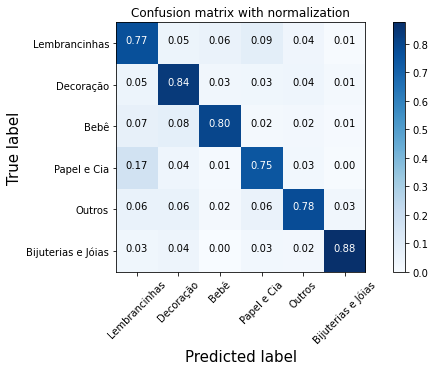

In [67]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,5))
plot_confusion_matrix(cnf_matrix, classes=["Lembrancinhas","Decoração",'Bebê',
                       'Papel e Cia','Outros','Bijuterias e Jóias'],normalize=True,
                      title='Confusion matrix with normalization')

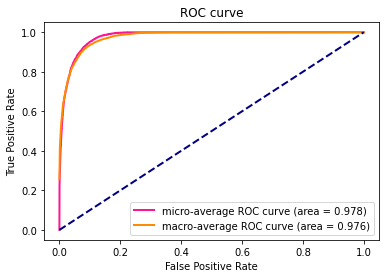

In [68]:
plot_ROC_curve(y_pred_class, y_score, 6, 'ROC curve')

#### Conclusão

Como esperado, a SVM se mostrou a técnica mais eficaz. A acurácia foi em torno de 84%, um resultado bem sólido, considerando que na matrix de confusão é possível notar que em todas as classes houve uma boa classicação, mesmo essas sejam bem desbalanceadas. As outras métricas também mostram a consistência do modelo.